In [111]:
 %config Completer.use_jedi = False

In [112]:
from tensorflow import keras

### Obtaining images from directory

The labels inferered from file structure and image size transformed to 90x90
The split between validation and training is automatically done with image_dataset_from_directory

I can use tf.keras.utils.get_file to download a file from a URL if it not already in the cache.

Example: 

path_to_downloaded_file = tf.keras.utils.get_file(
    "flower_photos",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True)
    
untar = boolean, whether the file should be decompressed

In [113]:
dataset_training = keras.preprocessing.image_dataset_from_directory(
    'data/flower_photos', 
    labels='inferred', 
    image_size=(90, 90),
    subset="training",
    validation_split=0.2,
    seed=50,
    batch_size=32
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [114]:
dataset_validation = keras.preprocessing.image_dataset_from_directory(
    'data/flower_photos', 
    labels='inferred', 
    image_size=(90, 90),
    subset="validation",
    validation_split=0.2,
    seed=50,
    batch_size=32
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [115]:
print(type(dataset_training))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [116]:
dataset_training.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Each batch has 32 images

(90, 90, 3)
(32,)


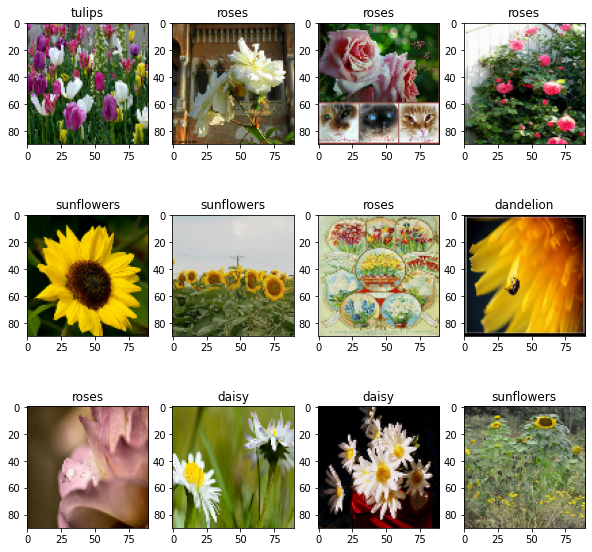

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for data, labels in dataset_training.take(1):
    print(data[0].shape)
    print(labels.shape)
    for i in range(12) :
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(data[i].numpy().astype("uint8"))
        plt.title(dataset_training.class_names[labels[i]])
    plt.show()

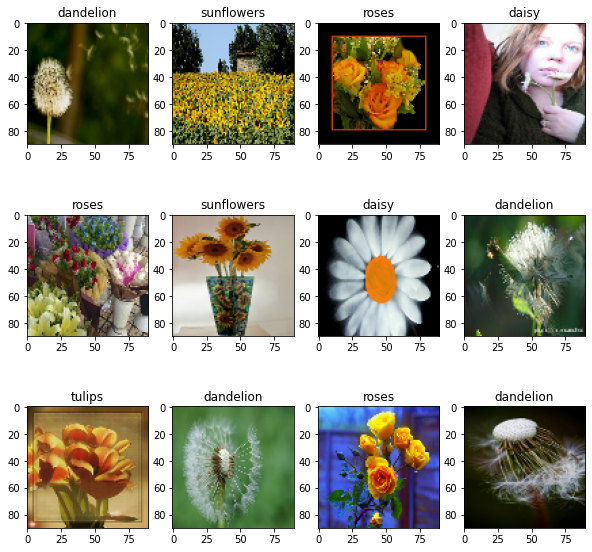

In [118]:
plt.figure(figsize=(10, 10))

for data, labels in dataset_validation.take(1):
    for i in range(12) :
        # print(data[i].shape)
        # print(labels[i].shape)
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(data[i].numpy().astype("uint8"))
        plt.title(dataset_validation.class_names[labels[i]])
    plt.show()

### Training the model using a transfer learning

List of pretrained models: https://keras.io/api/applications/

### Parameters:

- **include_top**: whether to include the fully-connected layer at the top of the network.
- **weights**: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.
- **pooling**: Optional pooling mode for feature extraction when include_top is False. None means that the output of the model will be the 4D tensor output of the last convolutional block. avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor. max means that global max pooling will be applied.
- **classes**: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.

include_top=False, because, I'm going to use my own input and output layer. 

In [119]:
pretrained_resnet = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(90, 90, 3),
    pooling='max',
    classes=5,
)

In [120]:
# all layers in this pretrained model is not trainable.
# do not learn the weights agains. does not change the weights this model has already learnt
# for layer in pretrained_resnet.layers:
#    layer.trainable = False

pretrained_resnet.trainable = False

In [121]:
# the input_shape is defined in the pre-trained model
# output shape is 5 classes, it's not one hot enconding
resnet = keras.Sequential([
    pretrained_resnet,
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

In [122]:
resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               1024500   
                                                                 
 dense_3 (Dense)             (None, 5)                 2505      
                                                                 
Total params: 24,614,717
Trainable params: 1,027,005
Non-trainable params: 23,587,712
_________________________________________________________________


In [123]:
resnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [124]:
history = resnet.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=15,
    batch_size=32
)

Epoch 1/15
92/92 [==============================] - 132s 1s/step - loss: 1.8170 - accuracy: 0.6877 - val_loss: 0.6863 - val_accuracy: 0.7657
Epoch 2/15
92/92 [==============================] - 132s 1s/step - loss: 0.3868 - accuracy: 0.8587 - val_loss: 0.6309 - val_accuracy: 0.7834
Epoch 3/15
92/92 [==============================] - 129s 1s/step - loss: 0.2429 - accuracy: 0.9111 - val_loss: 0.6471 - val_accuracy: 0.7984
Epoch 4/15
92/92 [==============================] - 125s 1s/step - loss: 0.1683 - accuracy: 0.9407 - val_loss: 0.6682 - val_accuracy: 0.7997
Epoch 5/15
92/92 [==============================] - 124s 1s/step - loss: 0.0784 - accuracy: 0.9782 - val_loss: 0.7093 - val_accuracy: 0.8106
Epoch 6/15
92/92 [==============================] - 115s 1s/step - loss: 0.0405 - accuracy: 0.9925 - val_loss: 0.6539 - val_accuracy: 0.8188
Epoch 7/15
92/92 [==============================] - 127s 1s/step - loss: 0.0235 - accuracy: 0.9966 - val_loss: 0.6520 - val_accuracy: 0.8215
Epoch 8/15
92

## Analyze the model

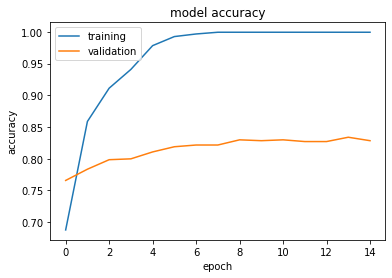

In [126]:
# Generate generalization metrics
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

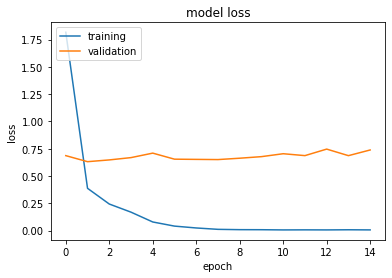

In [127]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

## Predictions

In [143]:
import cv2

In [144]:
import numpy as np

In [145]:
image = cv2.imread('data/flower_photos/sunflowers/6953297_8576bf4ea3.jpg')

In [146]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

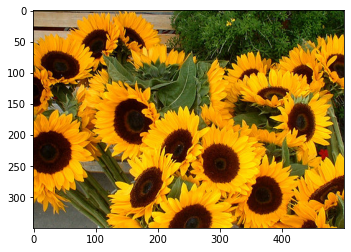

In [147]:
plt.imshow(image)
plt.show()

In [148]:
image_resized = cv2.resize(image, (90, 90))

Need to add an extra dimension at the beginning of images for batch sizes. Batch size represent how many images you bundle to feed the CNN at once. The batch can also be a single image, however it still needs that extra dimension of 1 to show the size of batch. https://stackoverflow.com/questions/62671394/how-to-interpret-expand-dims-while-predicting-a-uploaded-image-in-tensorflow

In [149]:
image_resized = np.expand_dims(image_resized, axis = 0)

In [151]:
image_resized.shape

(1, 90, 90, 3)

In [152]:
pred = resnet.predict(image_resized)

In [153]:
pred

array([[7.1768702e-11, 2.6183628e-11, 1.2355912e-04, 9.9987590e-01,
        4.5387236e-07]], dtype=float32)

In [154]:
output_class = dataset_training.class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is sunflowers


In [155]:
import os

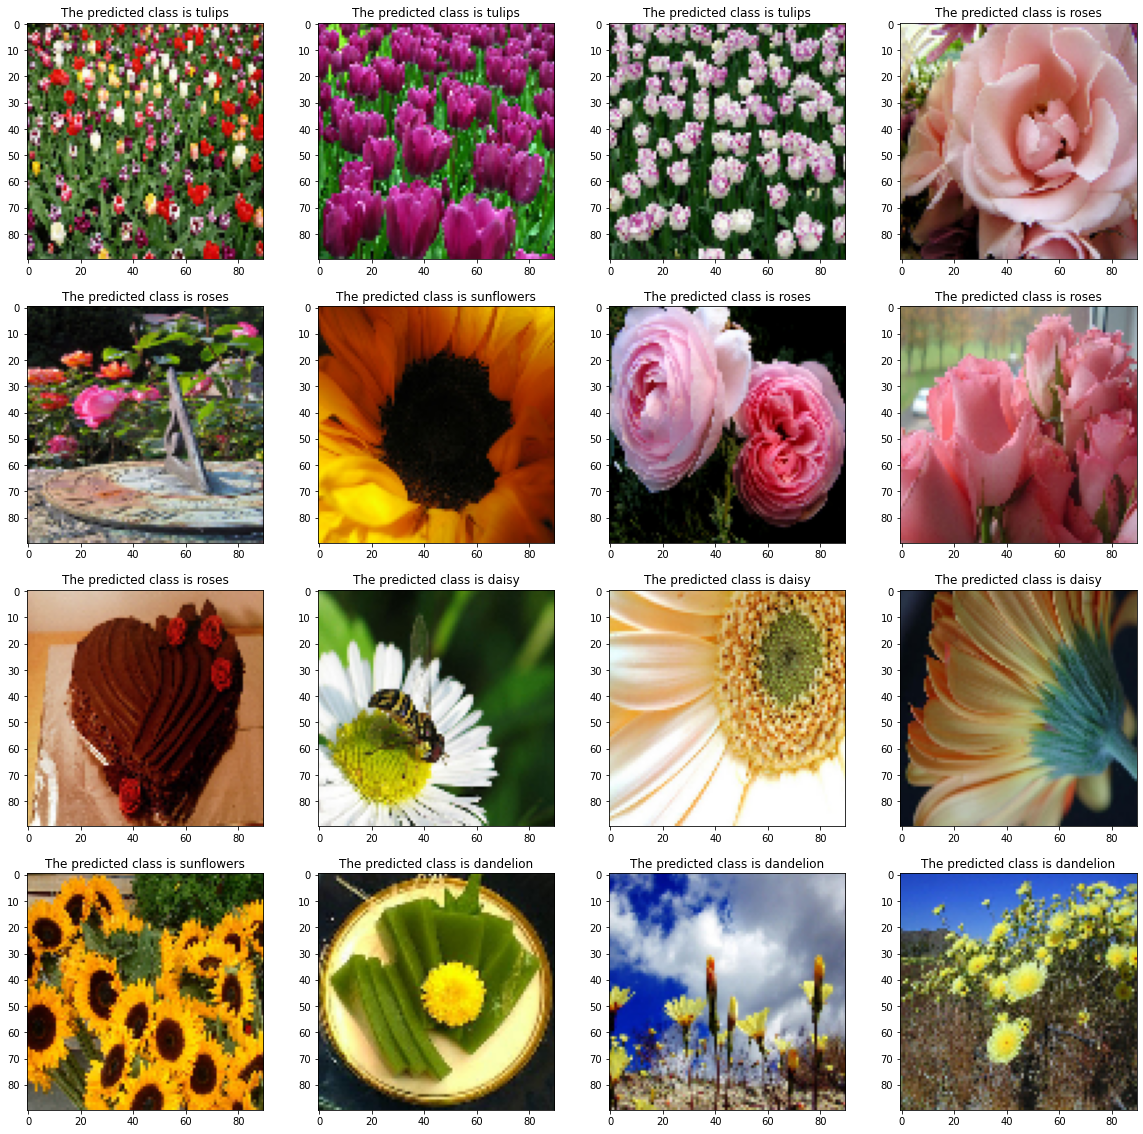

In [167]:
i = 0
plt.figure(figsize=(20, 20))
for filename in os.listdir('data/testing_flower/'):
    img = cv2.imread(os.path.join('data/testing_flower/', filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (90, 90))
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    img = np.expand_dims(img, axis = 0)
    pred = resnet.predict(img)
    output_class = dataset_training.class_names[np.argmax(pred)]
    plt.title("The predicted class is " + output_class)
    i+=1
    
plt.show()